# Predicting Vertebral Column Conditions

In this notebook, I will preprocess data on vertebral column conditions.

The dataset is from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Vertebral+Column

Attribute information:
1. Pelvic incidence
2. Pelvic tilt
3. Lumbar lordosis angle
4. Sacral slope
5. Pelvic radius
6. Grade of spondylolisthesis
7. Condition of vertebral column: NO = Normal, AB = Abnormal

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('vertebral.csv')
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Column1  310 non-null    float64
 1   Column2  310 non-null    float64
 2   Column3  310 non-null    float64
 3   Column4  310 non-null    float64
 4   Column5  310 non-null    float64
 5   Column6  310 non-null    float64
 6   Column7  310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


## Data Preprocessing

The columns names need to be updated.

In [4]:
# Update column names
df.rename(columns={'Column1':'Pelvic incidence', 'Column2':'Pelvic tilt', 'Column3':'Lumbar lordosis angle', 
                   'Column4':'Sacral slope', 'Column5':'Pelvic radius', 'Column6':'Grade of spondylolisthesis', 
                   'Column7':'Condition'}, inplace=True)
df.head()

,Pelvic incidence,Pelvic tilt,Lumbar lordosis angle,Sacral slope,Pelvic radius,Grade of spondylolisthesis,Condition
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


I will create a column called 'Class' where 1 is 'Abnormal' and 0 is 'Normal'.

In [5]:
df['Class'] = np.where(df['Condition'] == 'AB', 1, 0)

The column 'Condition' can be dropped.

In [6]:
df.drop('Condition', axis=1, inplace=True)

In [7]:
df.describe()

,Pelvic incidence,Pelvic tilt,Lumbar lordosis angle,Sacral slope,Pelvic radius,Grade of spondylolisthesis,Class
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742,0.677419
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883,0.468220
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000,0.000000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000,0.000000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000,1.000000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000,1.000000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000,1.000000


In [8]:
df['Class'].value_counts()

1    210
0    100
Name: Class, dtype: int64

This dataset is imbalanced, in that there are far more abnormal cases than normal ones. To address this, I will drop 52% of the Class 1 cases.

In [9]:
df = df.drop(df[df['Class'] ==1].sample(frac=.52).index)

In [10]:
df['Class'].value_counts()

1    101
0    100
Name: Class, dtype: int64

Now the dataset is balanced, so I will proceed to splitting the data into a train and a test set.

### Split Data

In [11]:
# Create training and test splits
train_data = df.sample(frac=0.7, random_state=0)
test_data = df.drop(train_data.index)

X_train = train_data.iloc[:,0:6]
X_test = test_data.iloc[:,0:6]
y_train = train_data.iloc[:,6:]
y_test = test_data.iloc[:,6:]

I will create a plot of the correlation matrix.

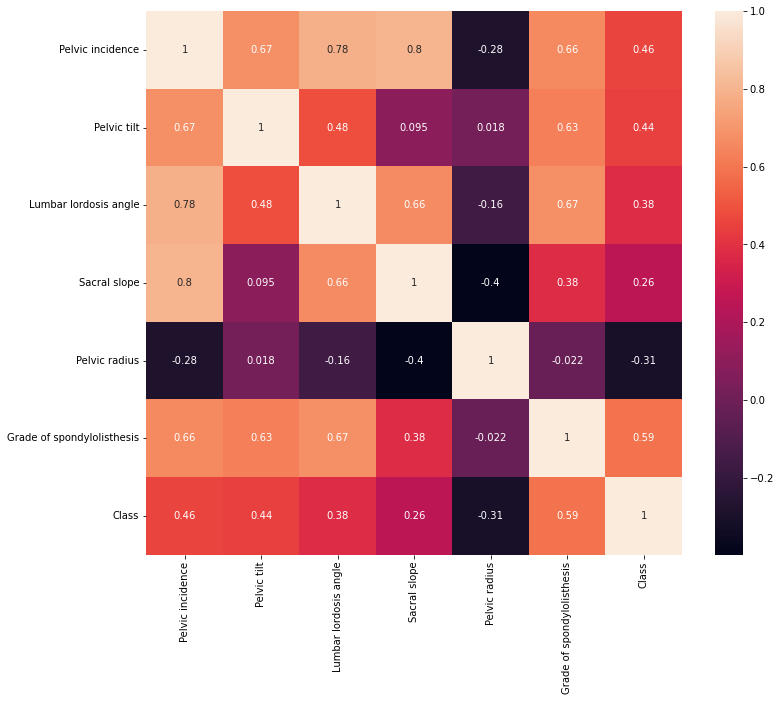

In [12]:
# Define data for correlation matrix
correlation_matrix_data = X_train.join(y_train).corr()

# Plot of correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix_data, annot=True)
plt.show()

To reduce the number of features, I will perform Principal Component Analysis (PCA).

## Principal Component Analysis (PCA)

Before applying PCA, I need to scale the data.

### Scale Data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled)
df_X_test_scaled = pd.DataFrame(X_test_scaled)

### Apply PCA

I will plot cumulative explained variance versus the number of principal components, which will show how well a given number of principal components can represent the data.

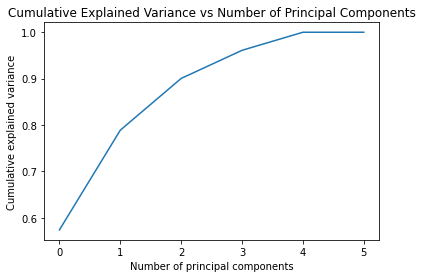

In [18]:
from sklearn.decomposition import PCA

pca = PCA().fit(df_X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance');


Two principal components should perform fairly well, but four will likely perform better. I will try both and compare the results. I will create data for two principal components now, and I will use pipelines in the next notebook to create the case with four principal components.

In [15]:
# Create train and test data with two principal components
pca_2 = PCA(n_components=2)
X_train_pca_2 = pca_2.fit_transform(df_X_train_scaled)
X_test_pca_2 = pca_2.transform(df_X_test_scaled)

## Export Preprocessed Data

I will export the preprocessed data for use in the Models notebook.

In [16]:
# Convert X_train_pca_2 and X_test_pca_2 to dataframes
df_X_train_pca_2 = pd.DataFrame(X_train_pca_2)
df_X_test_pca_2 = pd.DataFrame(X_test_pca_2)

# Export preprocessed data
df_X_train_pca_2.to_csv('X_train_2.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
df_X_test_pca_2.to_csv('X_test_2.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

I will also export the unscaled data, so that I can make pipelines which apply scaling, PCA with four principal components, and GridSearchCV in the Models notebook.

In [17]:
# Export preprocessed data
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)